# Feature Importance

- skip_exec: true


## Permutation Importance vs Random Forest Feature Importance (MDI)


In this example, we will compare the impurity-based feature importance of `RandomForestClassifier` with the permutation importance on the titanic dataset using `permutation_importance`. We will show that the impurity-based feature importance can inflate the importance of numerical features.

Furthermore, the impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.

This example shows how to use Permutation Importances as an alternative that can mitigate those limitations.


In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform, pdist
from sklearn.datasets import fetch_openml, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

pd.set_option("display.max_columns", None)

plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0


### Data Loading and Feature Engineering


Let’s use pandas to load a copy of the titanic dataset. The following shows how to apply separate preprocessing on numerical and categorical features.

We further include two random variables that are not correlated in any way with the target variable (survived):

`random_num` is a high cardinality numerical variable (as many unique values as records).

`random_cat` is a low cardinality categorical variable (3 possible values).


In [ ]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser="pandas")
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

We define a predictive model based on a random forest. Therefore, we will make the following preprocessing steps:

- use `OrdinalEncoder` to encode the categorical features;
- use `SimpleImputer` to fill missing values for numerical features using a mean strategy.


In [ ]:
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

### Accuracy of the Model


Prior to inspecting the feature importances, it is important to check that the model predictive performance is high enough. Indeed there would be little interest of inspecting the important features of a non-predictive model.

Here one can observe that the train accuracy is very high (the forest model has enough capacity to completely memorize the training set) but it can still generalize well enough to the test set thanks to the built-in bagging of random forests.

It might be possible to trade some accuracy on the training set for a slightly better accuracy on the test set by limiting the capacity of the trees (for instance by setting min_samples_leaf=5 or min_samples_leaf=10) so as to limit overfitting while not introducing too much underfitting.

However let’s keep our high capacity random forest model for now so as to illustrate some pitfalls with feature importance on variables with many unique values.


In [ ]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.814


### Tree’s Feature Importance from Mean Decrease in Impurity (MDI)


The impurity-based feature importance ranks the numerical features to be the most important features. As a result, the non-predictive `random_num` variable is ranked as one of the most important features!

This problem stems from two limitations of impurity-based feature importances:

impurity-based importances are biased towards high cardinality features;

impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).

The bias towards high cardinality features explains why `random_num` has a really large importance in comparison with `random_cat` while we would expect both random features to have a null importance.

The fact that we use training set statistics explains why both the `random_num` and `random_cat` features have a non-null importance.


In [ ]:
feature_names = rf[:-1].get_feature_names_out()
mdi_importances = pd.Series(rf[-1].feature_importances_, index=feature_names).sort_values(ascending=True)

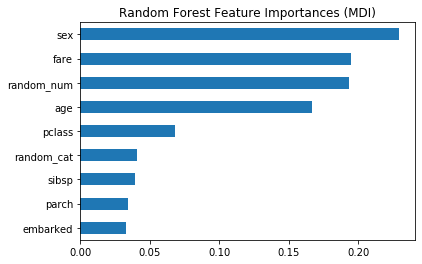

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Random Forest Feature Importances (MDI)")
mdi_importances.plot.barh(ax=ax)
plt.show()

As an alternative, the permutation importances of `rf` are computed on a held out test set. This shows that the low cardinality categorical features `sex` and `pclass` are the most important features. Indeed, permuting the values of these features will lead to most decrease in accuracy score of the model on the test set.

Also note that both random features have very low importances (close to 0) as expected.


In [ ]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

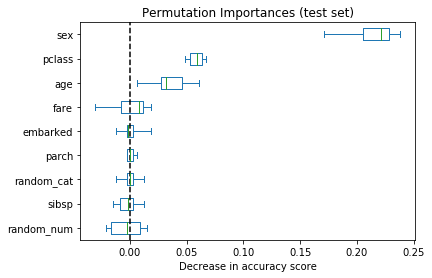

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Permutation Importances (test set)")
importances.plot.box(vert=False, whis=10, ax=ax)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
plt.show()

It is also possible to compute the permutation importances on the training set. This reveals that `random_num` and `random_cat` get a significantly higher importance ranking than when computed on the test set. The difference between those two plots is a confirmation that the RF model has enough capacity to use those random numerical and categorical features to overfit.


In [ ]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)


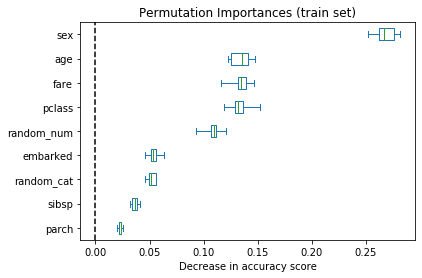

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Permutation Importances (train set)")
ax = importances.plot.box(vert=False, whis=10, ax=ax)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
plt.show()

We can retry the experiment by limiting the capacity of the trees to overfit by setting `min_samples_leaf` to 20 data points.


In [ ]:
rf.set_params(classifier__min_samples_leaf=20).fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=20, random_state=42))])

Observing the accuracy score on the training and testing set, we observe that the two metrics are very similar now. Therefore, our model is not overfitting anymore. We can then check the permutation importances with this new model.


In [ ]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.810
RF test accuracy: 0.832


In [ ]:
train_result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
test_results = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_importances_idx = train_result.importances_mean.argsort()

In [ ]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

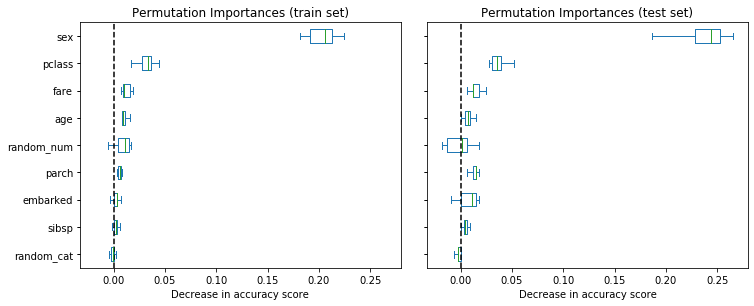

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
fig.tight_layout()
for name, importances, ax in zip(["train", "test"], [train_importances, test_importances], axes.flatten()):
    ax = importances.plot.box(vert=False, whis=10, ax=ax)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
plt.show()

Now, we can observe that on both sets, the `random_num` and `random_cat` features have a lower importance compared to the overfitting random forest. However, the conclusions regarding the importance of the other features are still valid.


## Permutation Importance with Multicollinear or Correlated Features


When features are collinear, permuting one feature will have little effect on the model's performance because it can get the same information from other correlated features. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.


### Handling Multicollinear Features


This is quite a fiddly process so we'll break it down step by step:


#### Spearman's Rank-Order Correlation


The `spearmanr` function from the `scipy.stats module` calculates Spearman rank-order correlation coefficient between two data arrays, or across the rows or columns of a 2-D array. This is a measure of the strength and direction of association between two ranked variables.

Here's the basic idea:

Ranking the Data: Spearman's correlation is based on the ranks of the data, rather than their raw values. Each value in each variable is replaced by its rank, including dealing with tied ranks.

Calculating the Correlation: Once the data are ranked, the same formula as Pearson's correlation coefficient is used, with the ranks replacing the raw data.

The formula to compute the Spearman's correlation coefficient $\rho$ is:

$$
\rho = 1 - \frac{6 \sum{d_i^2}}{n(n² - 1)}
$$

where $d_i$ are the differences between the ranks of corresponding variables, and $n$ is the number of observations.

The output is a correlation matrix if the input is a 2D array, or a correlation coefficient and p-value if the input consists of two 1D arrays.

The correlation matrix $\rho$ is a square symmetric matrix with ones on the diagonal (as each variable is perfectly correlated with itself), and the off-diagonal elements are the Spearman correlation coefficients between different variables. The corresponding p-values matrix can also be returned, which tells you the significance of the correlations.


In [ ]:
np.random.seed(0)
X = np.random.rand(10)
Y = np.random.rand(10)

rho, pval = spearmanr(X, Y)

print(f"Spearman's correlation coefficient: {rho}")
print(f"P-value: {pval}")

Spearman's correlation coefficient: 0.04242424242424241
P-value: 0.907363817812816


We can pass a 2-D matrix to `spearmanr` and calculate the correlation coefficient across the rows or columns of it.


In [ ]:
np.random.seed(0)
X = np.random.rand(10, 5)

rho, pval = spearmanr(X)


Each element in the `rho` matrix represents the correlation coefficient between two variables (i.e., columns of the input matrix). The `rho` matrix is symmetric, with a diagonal of ones, because each variable is perfectly correlated with itself.


In [ ]:
print(rho.shape)
rho


(5, 5)


array([[ 1.     ,  0.24848, -0.27273,  0.28485, -0.51515],
       [ 0.24848,  1.     , -0.53939,  0.33333, -0.50303],
       [-0.27273, -0.53939,  1.     ,  0.13939,  0.61212],
       [ 0.28485,  0.33333,  0.13939,  1.     , -0.09091],
       [-0.51515, -0.50303,  0.61212, -0.09091,  1.     ]])

The pval matrix represents the p-values associated with each correlation coefficient. A small p-value indicates that the correlation coefficient is statistically significant.


In [ ]:
np.set_printoptions(suppress=True, precision=5)
print(pval)
np.set_printoptions()


[[0.      0.48878 0.44584 0.42504 0.12755]
 [0.48878 0.      0.10759 0.34659 0.13833]
 [0.44584 0.10759 0.      0.70093 0.05997]
 [0.42504 0.34659 0.70093 0.      0.80277]
 [0.12755 0.13833 0.05997 0.80277 0.     ]]


#### Scipy's Squareform Function


The `scipy.spatial.distance.squareform` function is used for converting between a square, symmetric 2-D array (a full distance matrix) and a 1-D condensed distance matrix, and vice versa.

In the context of a full distance matrix, we can consider a 2-D array where the `[i, j]` entry represents the distance between the `i`-th and `j`-th elements. Since the distance from `i` to `j` is the same as from `j` to `i`, this matrix is symmetric. Additionally, the diagonal elements of the matrix (distance of elements to themselves) are always 0.

In a condensed distance matrix, we flatten the full matrix into a 1-D array. Here, we only keep one of the `i, j` or `j, i` pairs (since the matrix is symmetric, they're redundant), and we don't include the diagonal elements (since they're always 0). This saves space and can be more efficient for certain computations.

In general, the `squareform` function works as follows:

- From a full matrix to a condensed matrix:

  When the input is a 2-D square symmetric matrix, it returns a 1-D array containing the elements below the main diagonal. This is useful for saving space when you have a full distance matrix and you want to eliminate redundant information.

- From a condensed matrix to a full matrix:

  When the input is a 1-D condensed distance matrix, it returns a square symmetric 2-D distance matrix. This is useful when you have a condensed distance matrix and you want to visualize it or use it in computations that require a full matrix.


In [ ]:
arr = np.array([[0, 1, 2], [1, 0, 3], [2, 3, 0]])
arr


array([[0, 1, 2],
       [1, 0, 3],
       [2, 3, 0]])

In [ ]:
condensed = squareform(arr)
condensed


array([1, 2, 3])

In [ ]:
full = squareform(condensed)
full


array([[0, 1, 2],
       [1, 0, 3],
       [2, 3, 0]])

#### pdist


The `pdist` function from `scipy.spatial.distance` is used to compute the pairwise distances between observations in the input array `X`.

`pdist` stands for "pairwise distance". It takes a 2-D array where each row is an observation and each column is a feature of that observation, and it computes the distance between every pair of observations. This is also known as a condensed distance matrix.

By default, `pdist` uses the Euclidean distance (also known as the L2 norm or 2-norm distance), but it can also use other distance metrics. The distance metric can be specified via the `metric` parameter.


In [ ]:
X = np.array([[1, 2], [3, 4], [5, 6]])
X


array([[1, 2],
       [3, 4],
       [5, 6]])

For this small matrix we can calculate the pairwise distance by hand to see what `pdist` does for us:

$$
\begin{align}
d_1 &= \sqrt{(3-1)^2 + (4-2)^2} \\
&= \sqrt{8} \\
&= 2.828 \\
d_2 &= \sqrt{(5-1)^2 + (6-2)^2} \\
&= \sqrt{32} \\
&= 5.657 \\
d_3 &= \sqrt{(5-3)^2 + (6-4)^2} \\
&= \sqrt{8} \\
&= 2.828
\end{align}
$$

The number of pairwise distances is determined by the by the number of pairs of observations (rows) in `X`. If `X` has `n` rows there will be $\frac{n(n-1)}{2}$ pairs of observations. So there the output of `pdist` will be an array `d` of size $\frac{n(n-1)}{2}$. The size of `d` grows quadratically with `n`.


In [ ]:
D = pdist(X)
D


array([3.46410162, 6.92820323, 3.46410162])

#### Ward's Method


In [ ]:
# Create a random sample data
np.random.seed(0)
X = np.random.random((10, 3))
X


array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411],
       [0.43758721, 0.891773  , 0.96366276],
       [0.38344152, 0.79172504, 0.52889492],
       [0.56804456, 0.92559664, 0.07103606],
       [0.0871293 , 0.0202184 , 0.83261985],
       [0.77815675, 0.87001215, 0.97861834],
       [0.79915856, 0.46147936, 0.78052918],
       [0.11827443, 0.63992102, 0.14335329],
       [0.94466892, 0.52184832, 0.41466194]])

In [ ]:
# Calculate the pairwise distance of X
distance_matrix = pdist(X)
distance_matrix


array([0.29473397, 0.41689499, 0.19662693, 0.57216693, 0.86543108,
       0.46672837, 0.398299  , 0.63410319, 0.47902444, 0.57586803,
       0.41860234, 0.76350759, 0.63809564, 0.60361979, 0.29019522,
       0.69376753, 0.47216408, 0.44940452, 0.90274337, 0.94847268,
       0.34159159, 0.59112128, 0.91558599, 0.83389329, 0.51150232,
       0.88049546, 0.6034734 , 0.5875395 , 0.49193536, 0.63313412,
       1.27710576, 0.93324293, 0.87874855, 0.53771137, 0.65033634,
       1.10498141, 0.83929158, 0.92741024, 1.07781983, 0.4545101 ,
       1.08906121, 0.68336753, 0.94944076, 0.3983422 , 0.87776842])

The linkage matrix generated by the ward function (or any other linkage method in `scipy.cluster.hierarchy`) is an array with the shape `(n-1, 4)` where `n` is the number of observations in your input data. Each row in this matrix represents a single agglomeration (merge) event between two clusters during the hierarchical clustering process.

Here's how to interpret each column in the linkage matrix:

- Column 0 and Column 1: These columns represent the indices of the two clusters being merged in each agglomeration step. For the first `n` steps, where `n` is the number of input observations, the indices correspond to the input observations themselves. After the first `n` steps, the indices correspond to the newly-formed clusters, with indices starting from `n` and incrementing for each new cluster.
- Column 2: This column represents the distance between the two clusters being merged. In the case of Ward's method, this distance is calculated based on the increase in the total within-cluster variance after merging the two clusters.
- Column 3: This column contains the number of observations in the newly-formed cluster after the merge.


In [ ]:
# Perform Ward's method clustering
linkage_matrix = hierarchy.ward(distance_matrix)
linkage_matrix


array([[ 0.        ,  3.        ,  0.19662693,  2.        ],
       [ 1.        ,  7.        ,  0.29019522,  2.        ],
       [ 2.        ,  6.        ,  0.34159159,  2.        ],
       [ 9.        , 11.        ,  0.47575119,  3.        ],
       [ 4.        ,  8.        ,  0.53771137,  2.        ],
       [10.        , 12.        ,  0.63341709,  4.        ],
       [13.        , 15.        ,  0.82022065,  7.        ],
       [ 5.        , 16.        ,  1.13447788,  8.        ],
       [14.        , 17.        ,  1.21509521, 10.        ]])

The `dendrogram` method plots these merge events as a binary tree. Each leaf of the tree corresponds to one of the original observations. Each internal node of the tree corresponds to a merge event, with its two children being the clusters that were merged.

The y-coordinate of each internal node is the distance at which the corresponding merge event occurred (the third column of the corresponding row in the linkage matrix). This means that the height of each internal node in the dendrogram corresponds to the dissimilarity between the two clusters that it merged.

The x-coordinates of the nodes are chosen to place all leaves at the bottom of the plot and to avoid overlapping as much as possible.


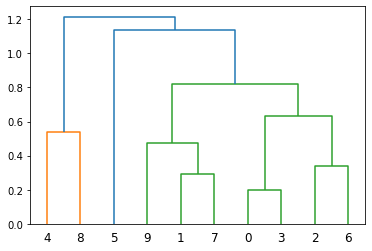

In [ ]:
# Plot the hierarchical clustering as a dendrogram.
hierarchy.dendrogram(linkage_matrix)
plt.show()


### Example


In this example, we compute the permutation importance on the Wisconsin breast cancer dataset using `permutation_importance`. The `RandomForestClassifier` can easily get about 97% accuracy on a test dataset.


In [ ]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [ ]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print(f"Accuracy on test data: {clf.score(X_test, y_test):.2f}")

Accuracy on test data: 0.97


Next, we plot the tree based feature importance and the permutation importance.

Because this dataset contains multicollinear features, the permutation importance will show that none of the features are important. In this case, permuting a feature drops the accuracy by at most 0.012, which would suggest that none of the features are important. This is in contradiction with the high test accuracy computed above: some feature must be important.


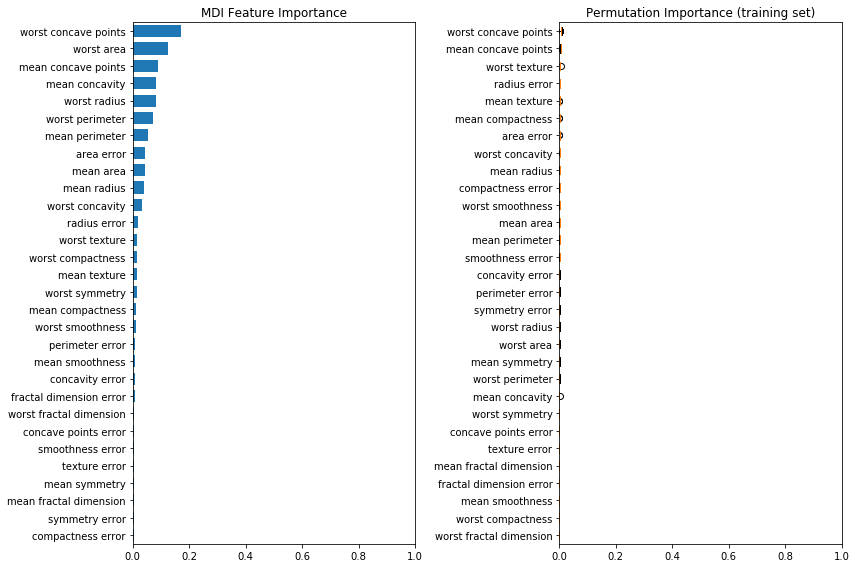

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax1.set_title("MDI Feature Importance")
ax1.set_xlim((0, 1))

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X.columns[perm_sorted_idx])
ax2.set_title("Permutation Importance (training set)")
ax2.set_xlim((0, 1))
fig.tight_layout()
plt.show()

One approach to handling multicollinearity is by performing hierarchical clustering on the features’ Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.

We can visualise how correlated our features are by plotting a dendrogram of the correlations as well as a heatmap. These suggest that all the columns relating to "size" are highly correlated with each other, as we would expect.


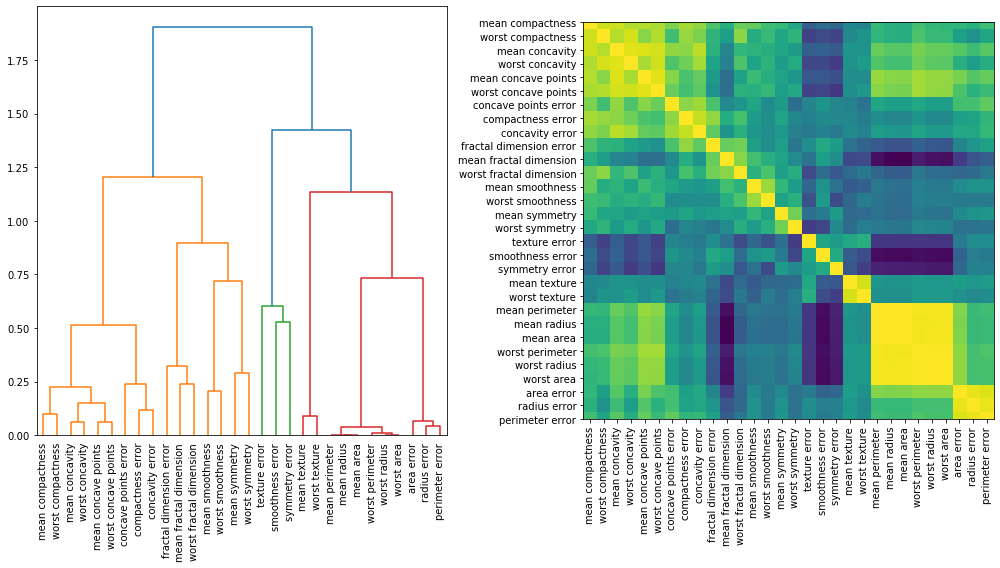

In [ ]:
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert correlation matrix to distance matrix before performing hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

dendro = hierarchy.dendrogram(dist_linkage, labels=X.columns, ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()


Next, we manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and choose a feature from each cluster to keep, select those features from our dataset, and train a new random forest. The test accuracy of the new random forest did not change much compared to the random forest trained on the complete dataset.


In [ ]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = [X.columns[i] for i in selected_features]

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(f"Accuracy on test data with features removed: {clf_sel.score(X_test_sel, y_test):.2f}")

Accuracy on test data with features removed: 0.97


Replotting the feature importances now gives us a much clearer picture of what is important. In this case, the radius is clearly the most important feature. This suggests that the various "size" features were cancelling each other out with their collinearity when we previously looked at the feature importance.


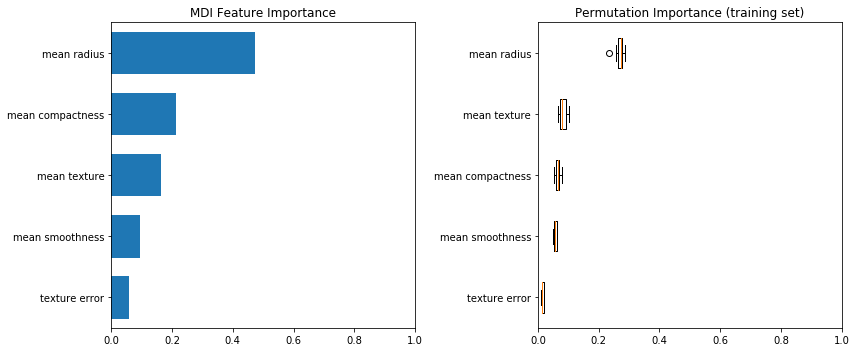

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

tree_importance_sorted_idx = np.argsort(clf_sel.feature_importances_)
tree_indices = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

ax1.barh(tree_indices, clf_sel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X_train_sel.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax1.set_title("MDI Feature Importance")
ax1.set_xlim((0, 1))

result = permutation_importance(clf_sel, X_train_sel, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X_train_sel.columns[perm_sorted_idx])
ax2.set_title("Permutation Importance (training set)")
ax2.set_xlim((0, 1))
fig.tight_layout()
plt.show()

## References and Links

- [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)
- [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)
